In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Let's begin by importing the data and checking out the first 5 rows. We can get a better sense of what type of data we are dealing with by doing this.

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')
df.head(10)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,1/25/2008,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,1/25/2008,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,1/25/2008,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,1/25/2008,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,1/25/2008,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
5,1201287889,1/25/2008,15,0,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,worldnews
6,1201289438,1/25/2008,5,0,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,worldnews
7,1201536662,1/28/2008,0,0,The U.N. Mismanagement Program,False,Moldavite,worldnews
8,1201558396,1/28/2008,4,0,Nicolas Sarkozy threatens to sue Ryanair,False,Moldavite,worldnews
9,1201635869,1/29/2008,3,0,US plans for missile shields in Polish town me...,False,JoeyRamone63,worldnews


This seems to be a database of reddit postings, with titles, poster ages, upvotes, downvotes, time, date, author, and category fields. Therefore, we can define our objective as trying to predict how many upvotes a post will get based on the other features. Our label for this dataset will be the up_votes column. The numerical features include time created, date created, and the categorical features include over_18 and category. The author and title fields are strings, which means we will need to perform some natural language processing on these columns.

Let's begin by splitting up the date created column into month, day, and year. We will define a function to do this.

In [3]:
def convert_date(df):
  month = []
  day = []
  year = []

  for i in range(len(df['date_created'])):
    if type(df['date_created'][i]) == str:
      current = df['date_created'][i].split('/')
      month.append(int(current[0]))
      day.append(int(current[1]))
      year.append(int(current[2]))
    else:
      month.append(0)
      day.append(0)
      year.append(0)

  df['month_created'] = month
  df['day_created'] = day
  df['year_created'] = year
  return df

In [4]:
df = convert_date(df)
df.drop('date_created', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

Now, we can see what the new transformed data looks like.

In [5]:
df.head(10)

,time_created,up_votes,down_votes,title,over_18,category,month_created,day_created,year_created
0,1201232046,3,0,Scores killed in Pakistan clashes,False,worldnews,1,25,2008
1,1201232075,2,0,Japan resumes refuelling mission,False,worldnews,1,25,2008
2,1201232523,3,0,US presses Egypt on Gaza border,False,worldnews,1,25,2008
3,1201233290,1,0,Jump-start economy: Give health care to all,False,worldnews,1,25,2008
4,1201274720,4,0,Council of Europe bashes EU&UN terror blacklist,False,worldnews,1,25,2008
5,1201287889,15,0,Hay presto! Farmer unveils the illegal mock-...,False,worldnews,1,25,2008
6,1201289438,5,0,"Strikes, Protests and Gridlock at the Poland-U...",False,worldnews,1,25,2008
7,1201536662,0,0,The U.N. Mismanagement Program,False,worldnews,1,28,2008
8,1201558396,4,0,Nicolas Sarkozy threatens to sue Ryanair,False,worldnews,1,28,2008
9,1201635869,3,0,US plans for missile shields in Polish town me...,False,worldnews,1,29,2008


Next, we encode the categorical features - category and over_18 - to numerical features, by using SkLearn's Ordinal Encoder.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df["category"] = ord_enc.fit_transform(df[["category"]])
df["over_18"] = ord_enc.fit_transform(df[["over_18"]])

We can now split our data into training and testing sets. Training sets will be used to train the model, while testing sets are a set of untouched data for the model to be tested on at the very end. 

In [7]:
from sklearn.model_selection import train_test_split
y = df["up_votes"].copy()
X = df.drop("up_votes", axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(407388, 8)
(101848, 8)
(407388,)
(101848,)


Since we have a field of strings (title), we can use SkLearn's count vectorizer to extract the necesary features from this column and change this column into multiple numerical ones. 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(max_features=1000, stop_words='english').fit(X_train['title'])
title_train = pd.DataFrame(cvec.transform(X_train['title']).todense(), columns=cvec.get_feature_names())

In [10]:
X_train.reset_index(drop=True, inplace=True)
title_train.reset_index(drop=True, inplace=True)

We can then add the transformed data back into our table. We will do the same for the testing data, making sure to delete unnecesary variables as we go as to not use up too much RAM.

In [11]:
X_train = pd.concat([X_train, title_train], axis=1)

In [12]:
del title_train

In [13]:
title_test = pd.DataFrame(cvec.transform(X_test['title']).todense(), columns=cvec.get_feature_names())

In [14]:
X_test = pd.concat([X_test, title_test], axis=1)

In [15]:
del title_test

This is what our new training set looks like. Instead of the title column, we now have columns indicating the frequency of each word. 

In [16]:
X_train = X_train.drop('title', axis=1)
X_train.head(10)

,time_created,down_votes,over_18,category,month_created,day_created,year_created,000,10,100,11,12,13,14,15,16,17,18,20,200,2012,2013,2014,2015,2016,24,25,30,300,40,50,500,60,abuse,access,according,accused,accuses,act,action,...,want,wanted,wants,war,warming,warned,warning,warns,washington,watch,water,way,weapons,wednesday,week,weeks,west,western,white,wife,wikileaks,win,wins,woman,women,won,work,workers,working,world,worst,worth,wounded,year,years,yemen,young,zealand,zimbabwe,zone
0,1292332988,0,0.0,0.0,12,14,2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1473724529,0,0.0,0.0,9,12,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1348590615,0,0.0,0.0,9,25,2012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1435702502,0,0.0,0.0,6,30,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1341934205,0,0.0,0.0,7,10,2012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1369997845,0,0.0,0.0,5,31,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,1339486141,0,0.0,0.0,6,12,2012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1454107207,0,0.0,0.0,1,29,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1393456620,0,0.0,0.0,2,26,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1415828880,0,0.0,0.0,11,12,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
y_pred = lin_reg.predict(X_train)
from sklearn.metrics import mean_squared_error

#Let's evaluate the model to see how well it did using mean square error.
lin_mse = mean_squared_error(y_train, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

531.784760931026

Across 400,000 rows, an RMSE of 531 is not optimal, but is still decent. We can determine what words contribute to the most upvotes - this is called feature importance. The feature importance relates to the coefficient values for each feature in the linear regression equation. The importance is calculated below. 

In [22]:
intercept = lin_reg.intercept_
features = pd.DataFrame(lin_reg.coef_, X_train.columns, columns=['coefficient'])
features.coefficient = features.coefficient.abs()
features.sort_values(by=['coefficient'], inplace=True, ascending=False)
features.head()

,coefficient
category,609615.306802
down_votes,83615.885871
year_created,691.540923
snowden,277.392912
over_18,252.348694


In [24]:
stdevs = []
for i in X_train.columns:
    stdev = X_train[i].std()
    stdevs.append(stdev)
 
import numpy as np
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features.sort_values(by=['importance'], inplace=True, ascending=False)
features.head(10)

,coefficient,stdev,importance
category,609615.306802,7.089578e+07,4.321915e+13
nsa,208.062927,8.766843e+00,1.824055e+03
over_18,252.348694,3.396257e+00,8.570410e+02
banned,200.941723,2.237599e+00,4.496270e+02
wikileaks,155.648661,1.517295e-01,2.361649e+01
year_created,691.540923,2.520625e-02,1.743115e+01
scientists,150.596576,9.668316e-02,1.456015e+01
declares,145.321697,8.028770e-02,1.166755e+01
way,45.988874,2.437499e-01,1.120979e+01
saudi,60.212919,1.620757e-01,9.759048e+00


As we can see from the table above, the category of the posting was the most important feature out of the numerical features, followed by the appearence of the word "nsa", and if the user was over 18. The NSA importance makes sense, as news about the NSA is not common, and the NSA is the top secret and most important security administration for our country, thus making it more likely to gather upvotes.

Linear regression is a very basic type of machine learning algorithm, and may not get into the complex relationships between the data. Therefore, we will also use a Decision Tree regressor to see if we can get our RMSE lower. 

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [26]:
y_pred = tree_reg.predict(X_train)

#Let's evaluate the model to see how well it did using mean square error.
from sklearn.metrics import mean_squared_error

tree_mse = mean_squared_error(y_train, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1.1921766286693545

This was a major improvement! From 500, we were able to get all the way down to 1.19. Similar to the linear regression model, we can print the feature importance, or a measure of how important each feature was in determining how many upvotes a post would get. 

In [27]:
importance = tree_reg.feature_importances_
for i,v in enumerate(importance):
	print('Feature number: %0d, Feature: %s, Score: %.5f' % (i, X_train.columns[i],v))

Feature number: 0, Feature: time_created, Score: 0.12554
Feature number: 1, Feature: down_votes, Score: 0.00000
Feature number: 2, Feature: over_18, Score: 0.00052
Feature number: 3, Feature: category, Score: 0.00000
Feature number: 4, Feature: month_created, Score: 0.03547
Feature number: 5, Feature: day_created, Score: 0.05241
Feature number: 6, Feature: year_created, Score: 0.00746
Feature number: 7, Feature: 000, Score: 0.00161
Feature number: 8, Feature: 10, Score: 0.00116
Feature number: 9, Feature: 100, Score: 0.00127
Feature number: 10, Feature: 11, Score: 0.00125
Feature number: 11, Feature: 12, Score: 0.00075
Feature number: 12, Feature: 13, Score: 0.00023
Feature number: 13, Feature: 14, Score: 0.00091
Feature number: 14, Feature: 15, Score: 0.00051
Feature number: 15, Feature: 16, Score: 0.00117
Feature number: 16, Feature: 17, Score: 0.00085
Feature number: 17, Feature: 18, Score: 0.00058
Feature number: 18, Feature: 20, Score: 0.00074
Feature number: 19, Feature: 200, Sco

We can plot the feature importances to see which word features contribute the most. 

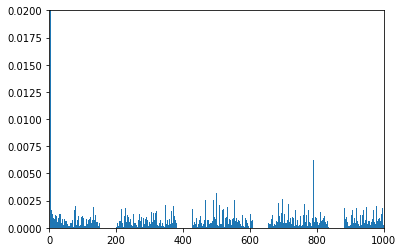

In [28]:
import matplotlib.pyplot as plt

plt.bar([x for x in range(len(importance))], importance)
plt.xlim(0, 1000)
plt.ylim(0, 0.02)
plt.show()

From here, it seems that there is a spike right before 800, that is much greater than the importance of any other feature (besides time posted, which was also the most important feature in the linear regression model). Let's zoom into that spike.

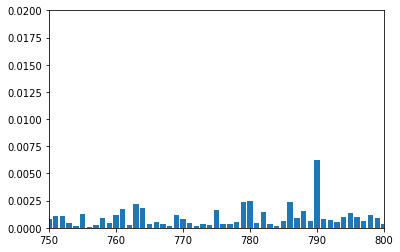

In [29]:
plt.bar([x for x in range(len(importance))], importance)
plt.ylim(0, 0.02)
plt.xlim(750, 800)
plt.show()

From our printed features, we can see that feature #790 is the word "says". Therefore, according to the decision tree model, a reddit post is most likely to get upvoted, by a far greater margin, if it contains the word "says". This makes sense, as people are interested in, and therefore more likely to upvote, news about an important person saying some controversial thing. The second largest spike occurs at 500, which is the word "korea". This also makes sense, as news about North Korea's unstable dictator Kim Jong Un is likely to receive more attention and thus more upvotes.